In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import gev_utils as gevu
import sa_utils as sau
import plotting_utils as pu

from utils import city_list
from utils import roar_code_path as project_code_path
from utils import roar_data_path as project_data_path
from utils import gev_metric_ids, gard_gcms

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

### Preliminaries

In [11]:
def plot_uc_metric(metric_id, proj_slice, return_period, grid, stationary, fit_method, norm, regrid_method, save, vmax_uc=40):
    # For titles
    title_labels = {
        'max_tasmax':f'Daily maximum temperature {return_period}-year return level',
        'max_cdd':f'Daily CDD {return_period}-year return level',
        'max_hdd':f'Daily HDD {return_period}-year return level',
        'max_pr':f'1-day precipitation {return_period}-year return level',
        'min_tasmin':f'Daily minimum temperature {return_period}-year return level',
    }

    # Make plot
    fig = plt.figure(figsize=(12, 5.75), layout='constrained')
    subfigs = fig.subfigures(2, 1, hspace=0.03)
    fig.suptitle(title_labels[metric_id], fontweight='bold', y=1.02)

    # Absolute value projection
    axsTop = subfigs[0].subplots(1, 5, subplot_kw=dict(projection=ccrs.LambertConformal()))
    subfigs[0].suptitle(f'{proj_slice} projection', style='italic', y=0.95)
    p = pu.plot_uc_map(
        metric_id = metric_id, 
        proj_slice = proj_slice,
        hist_slice = None,
        return_period = return_period,
        grid = grid,
        stationary = stationary,
        fit_method = fit_method,
        fig = subfigs[0],
        axs = axsTop,
        title = None,
        vmax_uc = vmax_uc,
        norm = norm,
        regrid_method = regrid_method,
    )

    # Change from historical
    axsBottom = subfigs[1].subplots(1, 5, subplot_kw=dict(projection=ccrs.LambertConformal()))
    subfigs[1].suptitle(f'{proj_slice} change from historical (1950-2014)', style='italic', y=0.95)
    p = pu.plot_uc_map(
        metric_id = metric_id, 
        proj_slice = proj_slice,
        hist_slice = '1950-2014',
        return_period = return_period,
        grid = grid,
        stationary = stationary,
        fit_method = fit_method,
        fig = subfigs[1],
        axs = axsBottom,
        title = None,
        norm = norm,
        vmax_uc = vmax_uc,
        regrid_method = regrid_method,
    )

    if save:
        stat_str = "stat" if stationary else "nonstat"
        plt.savefig(f'../figs/{metric_id}_{proj_slice}_1950-2014_{return_period}yr_return_level_{fit_method}_{stat_str}_{grid}grid_{regrid_method}.png', dpi=400, bbox_inches='tight')
    else:
        plt.show()

## Analysis

In [3]:
%%time
# Calculate all and store
grid = "LOCA2"
regrid_method = "nearest"
proj_slice = "2050-2100"
hist_slices = [None, "1950-2014"]
return_levels = [10,25,50,100]
fit_method = "lmom"
stationary = True
stat_str = "stat" if stationary else "nonstat"

# Loop through metrics
for metric_id in gev_metric_ids:
    # Do for projection, change
    for hist_slice in hist_slices:
        # Loop through return levels
        for return_level in return_levels:
            # Check if done
            col_name = f"{return_level}yr_return_level"
            save_path = f"{project_data_path}/results/{metric_id}_{proj_slice}_{hist_slice}_{col_name}_{fit_method}_{stat_str}_{grid}grid_{regrid_method}.nc"
            # Calculate
            if not os.path.exists(save_path):
                uc = sau.uc_all(metric_id=metric_id,
                            grid=grid,
                            fit_method=fit_method,
                            stationary=stationary,
                            regrid_method=regrid_method,
                            proj_slice=proj_slice,
                            hist_slice=hist_slice,
                            col_name=col_name)
                # Store
                uc.to_netcdf(save_path)
                print(f"Done: {save_path.split('/')[-1]}")
                del uc # memory management
            else:
                print(f"Already done: {save_path.split('/')[-1]}")

/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/results/max_tasmax_2050-2100_None_100yr_return_level_lmom_stat_LOCA2grid_nearest.nc
/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/loca_grid/max_tasmax/STAR-ESDM_*_2050-2100_stat_lmom_main_nearest.nc
/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/loca_grid/max_tasmax/STAR-ESDM_*_2050-2100_1950-2014_stat_lmom_bootstrap_nearest.nc


/storage/work/dcl5300/current_projects/conus_comparison_lafferty-etal-2024/.venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Done: max_tasmax_2050-2100_None_100yr_return_level_lmom_stat_LOCA2grid_nearest.nc
/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/results/max_tasmax_2050-2100_1950-2014_100yr_return_level_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_1950-2014_100yr_return_level_lmom_stat_LOCA2grid_nearest.nc
CPU times: user 5min 37s, sys: 2min 40s, total: 8min 18s
Wall time: 9min 17s


## Plots

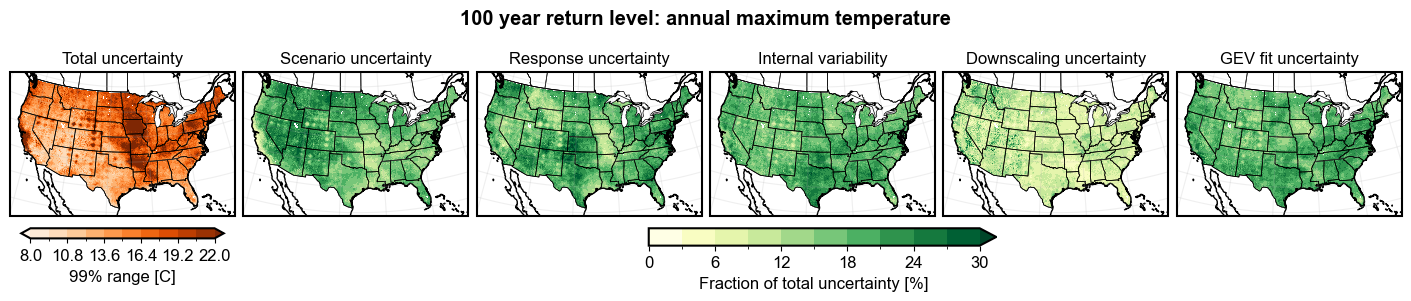

In [7]:
pu.plot_uc_map(
    metric_id="max_tasmax",
    proj_slice="2050-2100",
    hist_slice=None,
    plot_col="100yr_return_level",
    return_period=100,
    grid="LOCA2",
    fit_method="lmom",
    stationary=True,
    analysis_type="extreme_value",
    regrid_method="nearest",
    norm="uc_99w",
    vmax_uc=30,
)

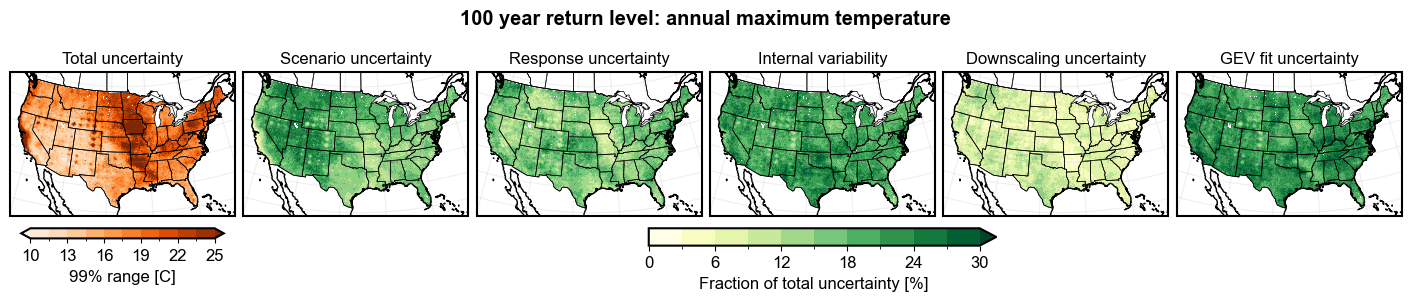

In [8]:
pu.plot_uc_map(
    metric_id="max_tasmax",
    proj_slice="2050-2100",
    hist_slice="1950-2014",
    plot_col="100yr_return_level",
    return_period=100,
    grid="LOCA2",
    fit_method="lmom",
    stationary=True,
    analysis_type="extreme_value",
    regrid_method="nearest",
    norm="uc_99w",
    vmax_uc=30,
)

In [ ]:
proj_slice = '2050-2100'
return_period = 100
grid = 'LOCA2'
stationary = True
fit_method = 'lmom'
norm = 'uc_95w'
regrid_method = 'nearest'

for metric_id in gev_metric_ids:
    plot_uc_metric(metric_id = metric_id,
                   proj_slice = proj_slice,
                   return_period = return_period,
                   grid = grid,
                   stationary = stationary,
                   fit_method = fit_method,
                   norm = norm,
                   regrid_method=regrid_method,
                   save = True
                  )

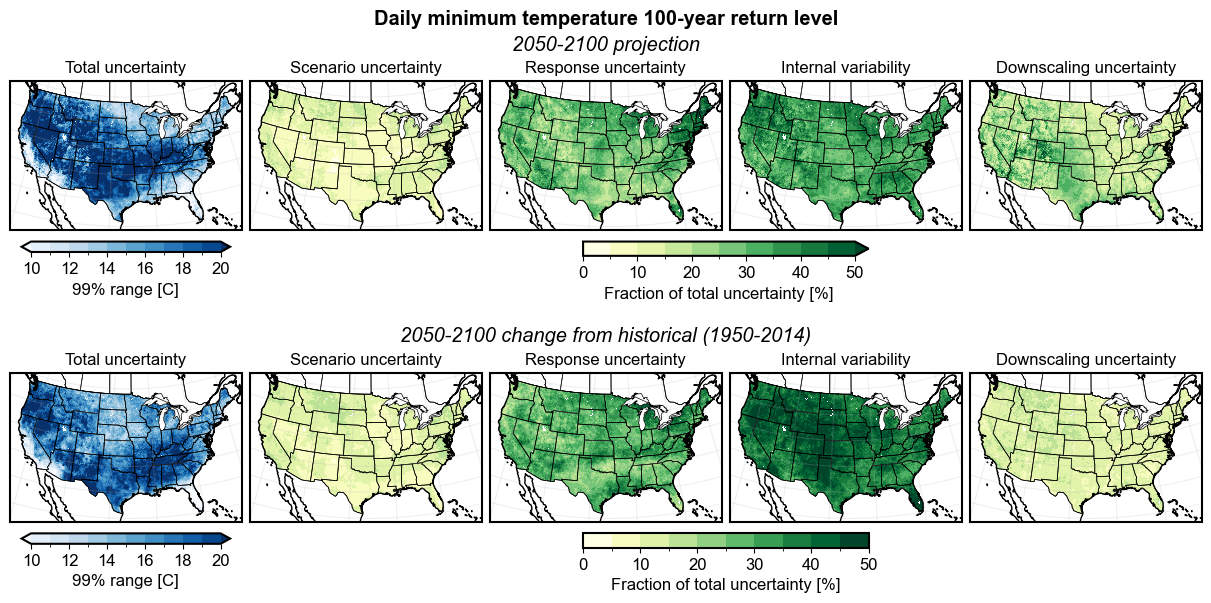

In [10]:
proj_slice = '2050-2100'
return_period = 100
grid = 'LOCA2'
stationary = True
fit_method = 'lmom'
norm = 'uc_99w'
regrid_method = 'nearest'

plot_uc_metric(metric_id = 'min_tasmin',
               proj_slice = proj_slice,
               return_period = return_period,
               grid = grid,
               stationary = stationary,
               fit_method = fit_method,
               norm = norm,
               regrid_method=regrid_method,
               save = True,
               vmax_uc = 50.,
              )

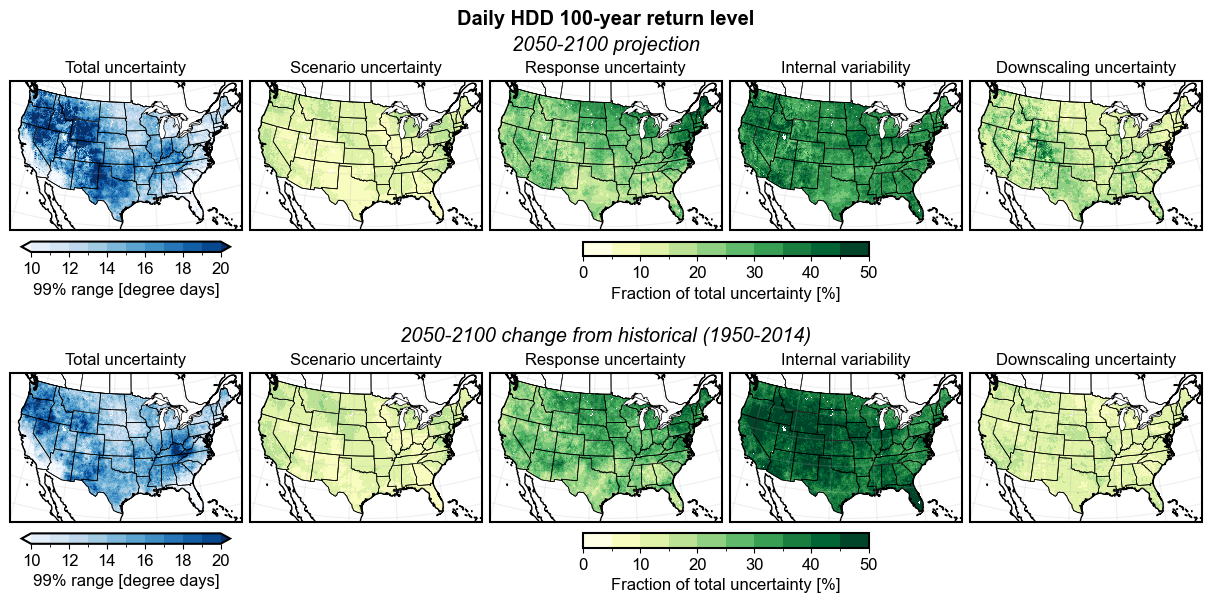

In [12]:
proj_slice = '2050-2100'
return_period = 100
grid = 'LOCA2'
stationary = True
fit_method = 'lmom'
norm = 'uc_99w'
regrid_method = 'nearest'

plot_uc_metric(metric_id = 'max_hdd',
               proj_slice = proj_slice,
               return_period = return_period,
               grid = grid,
               stationary = stationary,
               fit_method = fit_method,
               norm = norm,
               regrid_method=regrid_method,
               save = True,
               vmax_uc = 50.,
              )